In [15]:
# This notebook can be used to analyze a model. ANY model. We are just going to 
# load this model on up, then run the validation data through it, and get make a nice confusion matrix
# from the results :)
#
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, model_from_json
from keras import backend as K 
from keras.layers import Dropout, Flatten, Dense

import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import imageio as io

###################################################
# You put the file names in here                  #
#                                                 #
json_file = 'VGG19_transfer[m1]_3.json'
weight_file_name = 'VGG19_transfer[m1]_3.h5'
test_dir = './cropped_split_dataset/test'



####################################################
# And you put the model architecture info here     #
#                                                  #
loss = 'categorical_crossentropy'
num_units_first_dense = 986 
dropout_rate = 0.3867433627389078
num_units_second_dense = 1043
lr = 0.006072113068495087
momentum = 0.7963386502886618



####################################################
#       Where the magic happens                    #
#                                                  #  
model_json = open('./models_json/' + json_file, 'r')
loaded_model_json = model_json.read()
model_json.close()
model = model_from_json(loaded_model_json)
print('Model loaded from json...')

l = model.output
l = Flatten()(l)
l = Dense(num_units_first_dense, activation='relu')(l)
l = Dropout(dropout_rate)(l)
l = Dense(num_units_second_dense, activation='relu')(l)
final = Dense(2, activation='softmax')(l)
model = Model(inputs=model.input, outputs=final)
print('Extra layers of model added')

weight_file = './weights/' + weight_file_name
model.load_weights(weight_file)
print('Model weights loaded from disk...')

model.compile(
     loss=loss,
     optimizer=optimizers.SGD(lr=lr, momentum=momentum),
     metrics=['accuracy'])
print('Model Compiled')

model.summary()

Model loaded from json...
Extra layers of model added
Model weights loaded from disk...
Model Compiled
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_______________________________________

In [16]:
# Here is where we do the predictions and evaluations
#
img_height, img_width = 128, 128

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=(img_height, img_width),
        class_mode='categorical')

predictions = model.predict_generator(test_generator, use_multiprocessing=True)
evaluations = model.evaluate_generator(test_generator, use_multiprocessing=True)

Found 11878 images belonging to 2 classes.


In [17]:
print('Performance of evaluation')
print(model.metrics_names)
print(evaluations)  # 96.9 accuracy Boiiiiii

Performance of evaluation
['loss', 'acc']
[0.07753530068310942, 0.969439299545378]


In [18]:
# Taken from scikit learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2723   78]
 [ 285 8792]]
Normalized confusion matrix
[[0.97 0.03]
 [0.03 0.97]]


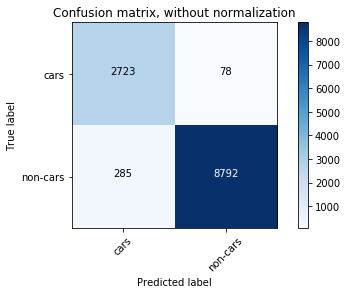

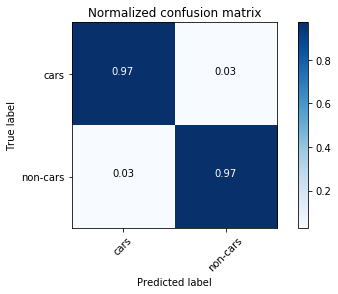

In [6]:
# Now to makea confusion matrix so that we can see some more precise 
# performance statistics
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=-1)

# Compute confusion matrix
# Plot non-normalized  && normalized confusion matrices
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
class_names = ['cars', 'non-cars']


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [195]:
# DELIVERABLES 
#    1.) Cool visualizations of key layers                                            [CHECK] 
#        - The re-trained conv layers (maybe before & after)
#        - Exploration of which layers ARE key layers of VGG/show them
#
#    2.) Output all false negative vehicles/false positive vehicles into directories  [CHECK ISH]
#        and analyze them
#        - Visualizing activations at key layers when put in
#        - Perform Human-level search for common undetected features
#        - Possibly heatmaps? 
#
#    3.) Find top 5 images which cause highest activations--both for the car and the  [     ] 
#        non-car class
#
#    4.) Get performance statistics and confusion matrices for the trained model      [CHECK] 
#

In [ ]:
# Here we will identify all images which are misclassified, and write them to a directory 
#    
# Current Thoughts: Iterate over batches in validation_generator, 
#                     - Round output predictions to nearest integer 
#                     - Compare output with GT to see if mis-classified 
#                        * Check if it was a CAR false-negative (gt == car, pred == non-car)  
#                            Output image data to ./analyze/car directory
#                        * Else it was a non-car classified as a car 
#                            Output image data to ./analyze/non-car directory
tdg = ImageDataGenerator(rescale=1./255)
t_gen = tdg.flow_from_directory(
        test_dir,
        batch_size=1,
        shuffle=False,
        target_size=(img_height, img_width),
        class_mode='categorical')

count = 0


for i, batch in enumerate(t_gen):
    gt = np.argmax(batch[1]) # Confident in this
    pred = np.argmax(model.predict_on_batch(batch[0]))
    
    if gt != pred:
        count = count + 1
        print('Epoch: ' + str(i) + '  count: ' + str(count))
    
        if gt == 0:
            io.imwrite('./analyze/car_false_neg/img' + str(count) + '.jpg', batch[0][0])   
        else:   
            io.imwrite('./analyze/non_car_false_pos/img' + str(count) + '.jpg', batch[0][0])   
    
    # For some reason, the generator can be enumerated over for longer than the total number of 
    # images in the directory... Possibly some interaction between the enumerate & keras classes. 
    if i > 11878:
        break
    

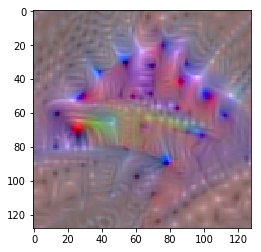

In [20]:
# Here we are going to do some exploration with visualizing the actual layers of the network
#
# Here's the layer names:
# ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 
#  'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 
#  'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool', 'flatten_13',
#  'dense_37', 'dropout_13', 'dense_38', 'dense_39']
#
from keras import activations
from vis.utils import utils
from vis.visualization import visualize_activation
from vis.input_modifiers import Jitter

layer_names = [m.name for m in model.layers]

# We need to swap the softmax activation with a linear activation for some reason which is unclear to me,
# but which was in the keras-vis docs. Has to do with allowing proper gradient flow
pred_index = utils.find_layer_idx(model, 'dense_6')
model.layers[pred_index].activation = activations.linear
model = utils.apply_modifications(model)


# Here we are using the "visualize_activation" method to create a "maximally activating" input image for the 
# car class (indicated by the "filter_indices=0" param)
imgs = []
img = visualize_activation(model, pred_index, filter_indices=1, max_iter=800, input_modifiers=[Jitter(16)])
#imgs.append(img)
#imgs.append(visualize_activation(model, pred_index, filter_indices=1, max_iter=500, input_modifiers=[Jitter(16)]))

plt.imshow(img)
plt.show()


Iteration: 1, named_losses: <zip object at 0x7fe3ced1d548>, overall loss: 6384.8916015625
Iteration: 2, named_losses: <zip object at 0x7fe3ced0f8c8>, overall loss: 3163.8837890625
Iteration: 3, named_losses: <zip object at 0x7fe3ceccb548>, overall loss: 1523.6031494140625
Iteration: 4, named_losses: <zip object at 0x7fe3ced01908>, overall loss: 652.2512817382812
Iteration: 5, named_losses: <zip object at 0x7fe3ced01608>, overall loss: 227.3036651611328
Iteration: 6, named_losses: <zip object at 0x7fe3ced01d88>, overall loss: 72.04301452636719
Iteration: 7, named_losses: <zip object at 0x7fe3ced01f48>, overall loss: 76.61409759521484
Iteration: 8, named_losses: <zip object at 0x7fe3ced01208>, overall loss: 63.29034423828125
Iteration: 9, named_losses: <zip object at 0x7fe3ced71d88>, overall loss: 65.64849090576172
Iteration: 10, named_losses: <zip object at 0x7fe3ced71988>, overall loss: 53.64445877075195
Iteration: 11, named_losses: <zip object at 0x7fe3ced71b48>, overall loss: 54.4486

Iteration: 94, named_losses: <zip object at 0x7fe3ceda5648>, overall loss: 19.378496170043945
Iteration: 95, named_losses: <zip object at 0x7fe3ceccb788>, overall loss: 20.05419158935547
Iteration: 96, named_losses: <zip object at 0x7fe3ced3cb08>, overall loss: 19.248355865478516
Iteration: 97, named_losses: <zip object at 0x7fe3ced52d48>, overall loss: 20.25747299194336
Iteration: 98, named_losses: <zip object at 0x7fe3ced93648>, overall loss: 19.40435791015625
Iteration: 99, named_losses: <zip object at 0x7fe3ced2e308>, overall loss: 20.101083755493164
Iteration: 100, named_losses: <zip object at 0x7fe3ced0fd48>, overall loss: 19.595535278320312
Iteration: 101, named_losses: <zip object at 0x7fe3ced61f88>, overall loss: 20.00654411315918
Iteration: 102, named_losses: <zip object at 0x7fe3ced61d08>, overall loss: 19.413549423217773
Iteration: 103, named_losses: <zip object at 0x7fe3ced3c588>, overall loss: 19.654943466186523
Iteration: 104, named_losses: <zip object at 0x7fe3ced52d48>

Iteration: 184, named_losses: <zip object at 0x7fe3ced71988>, overall loss: 19.484336853027344
Iteration: 185, named_losses: <zip object at 0x7fe3ced2e1c8>, overall loss: 19.700223922729492
Iteration: 186, named_losses: <zip object at 0x7fe3ced93648>, overall loss: 19.328954696655273
Iteration: 187, named_losses: <zip object at 0x7fe3ced0fd48>, overall loss: 19.60946273803711
Iteration: 188, named_losses: <zip object at 0x7fe3cec94c88>, overall loss: 20.05438232421875
Iteration: 189, named_losses: <zip object at 0x7fe3ceda5648>, overall loss: 18.943693161010742
Iteration: 190, named_losses: <zip object at 0x7fe3ced45ac8>, overall loss: 20.155006408691406
Iteration: 191, named_losses: <zip object at 0x7fe3ced61508>, overall loss: 19.343730926513672
Iteration: 192, named_losses: <zip object at 0x7fe3cef15e48>, overall loss: 19.9903507232666
Iteration: 193, named_losses: <zip object at 0x7fe3ced2e088>, overall loss: 18.796140670776367
Iteration: 194, named_losses: <zip object at 0x7fe3ced

Iteration: 75, named_losses: <zip object at 0x7fe3cea70948>, overall loss: 19.259389877319336
Iteration: 76, named_losses: <zip object at 0x7fe3cfba2588>, overall loss: 20.794960021972656
Iteration: 77, named_losses: <zip object at 0x7fe3ce9f43c8>, overall loss: 19.40132713317871
Iteration: 78, named_losses: <zip object at 0x7fe3ce9f48c8>, overall loss: 20.460050582885742
Iteration: 79, named_losses: <zip object at 0x7fe3cea524c8>, overall loss: 18.90801429748535
Iteration: 80, named_losses: <zip object at 0x7fe3cea42ec8>, overall loss: 20.541339874267578
Iteration: 81, named_losses: <zip object at 0x7fe3ce9f4cc8>, overall loss: 19.38780403137207
Iteration: 82, named_losses: <zip object at 0x7fe3cea7fe88>, overall loss: 20.558486938476562
Iteration: 83, named_losses: <zip object at 0x7fe3cea7f908>, overall loss: 19.449438095092773
Iteration: 84, named_losses: <zip object at 0x7fe3cea42288>, overall loss: 20.33363151550293
Iteration: 85, named_losses: <zip object at 0x7fe3cea1ca48>, ove

Iteration: 163, named_losses: <zip object at 0x7fe3ce9f4c48>, overall loss: 19.6083984375
Iteration: 164, named_losses: <zip object at 0x7fe3ce9f4d08>, overall loss: 19.773839950561523
Iteration: 165, named_losses: <zip object at 0x7fe3cea7ff48>, overall loss: 19.245220184326172
Iteration: 166, named_losses: <zip object at 0x7fe3ceab1a08>, overall loss: 20.03669548034668
Iteration: 167, named_losses: <zip object at 0x7fe3cea7fe88>, overall loss: 19.308517456054688
Iteration: 168, named_losses: <zip object at 0x7fe3cea1cc08>, overall loss: 19.985727310180664
Iteration: 169, named_losses: <zip object at 0x7fe3ce9f4bc8>, overall loss: 19.339052200317383
Iteration: 170, named_losses: <zip object at 0x7fe3cea86548>, overall loss: 19.928340911865234
Iteration: 171, named_losses: <zip object at 0x7fe3cea86148>, overall loss: 19.299039840698242
Iteration: 172, named_losses: <zip object at 0x7fe3ce9f4d48>, overall loss: 19.829742431640625
Iteration: 173, named_losses: <zip object at 0x7fe3cea1c

Iteration: 58, named_losses: <zip object at 0x7fe3ce708888>, overall loss: 20.367935180664062
Iteration: 59, named_losses: <zip object at 0x7fe3ce6d3b88>, overall loss: 21.281370162963867
Iteration: 60, named_losses: <zip object at 0x7fe3ce7e2148>, overall loss: 19.88267707824707
Iteration: 61, named_losses: <zip object at 0x7fe3ce7b1e08>, overall loss: 21.27861785888672
Iteration: 62, named_losses: <zip object at 0x7fe3ce900648>, overall loss: 19.519357681274414
Iteration: 63, named_losses: <zip object at 0x7fe3ce7b18c8>, overall loss: 21.202239990234375
Iteration: 64, named_losses: <zip object at 0x7fe3ce76cc48>, overall loss: 19.596166610717773
Iteration: 65, named_losses: <zip object at 0x7fe3ce6d3d48>, overall loss: 21.245744705200195
Iteration: 66, named_losses: <zip object at 0x7fe3ce7839c8>, overall loss: 19.52876853942871
Iteration: 67, named_losses: <zip object at 0x7fe3ce8963c8>, overall loss: 20.919292449951172
Iteration: 68, named_losses: <zip object at 0x7fe3ce6d3888>, ov

Iteration: 153, named_losses: <zip object at 0x7fe3ce6d3fc8>, overall loss: 21.581039428710938
Iteration: 154, named_losses: <zip object at 0x7fe3ce76c948>, overall loss: 18.077030181884766
Iteration: 155, named_losses: <zip object at 0x7fe3ce973dc8>, overall loss: 21.496747970581055
Iteration: 156, named_losses: <zip object at 0x7fe3ce7b18c8>, overall loss: 17.961181640625
Iteration: 157, named_losses: <zip object at 0x7fe3ce74d048>, overall loss: 20.91179847717285
Iteration: 158, named_losses: <zip object at 0x7fe3ce74d688>, overall loss: 18.627323150634766
Iteration: 159, named_losses: <zip object at 0x7fe3ce900648>, overall loss: 20.45438003540039
Iteration: 160, named_losses: <zip object at 0x7fe3ce7d3548>, overall loss: 18.882917404174805
Iteration: 161, named_losses: <zip object at 0x7fe3ce6d3b88>, overall loss: 20.32268524169922
Iteration: 162, named_losses: <zip object at 0x7fe3ce6d3bc8>, overall loss: 18.920833587646484
Iteration: 163, named_losses: <zip object at 0x7fe3ce75c

Iteration: 51, named_losses: <zip object at 0x7fe3ce4b8f48>, overall loss: 20.093427658081055
Iteration: 52, named_losses: <zip object at 0x7fe3ce4a6048>, overall loss: 22.219209671020508
Iteration: 53, named_losses: <zip object at 0x7fe3ce42eb88>, overall loss: 19.9427490234375
Iteration: 54, named_losses: <zip object at 0x7fe3ce465888>, overall loss: 21.924287796020508
Iteration: 55, named_losses: <zip object at 0x7fe3ce4df088>, overall loss: 19.772109985351562
Iteration: 56, named_losses: <zip object at 0x7fe3ce42ec48>, overall loss: 22.146562576293945
Iteration: 57, named_losses: <zip object at 0x7fe3ce4eea08>, overall loss: 19.462141036987305
Iteration: 58, named_losses: <zip object at 0x7fe3ce530548>, overall loss: 22.371726989746094
Iteration: 59, named_losses: <zip object at 0x7fe3ce42efc8>, overall loss: 18.857086181640625
Iteration: 60, named_losses: <zip object at 0x7fe3ce4eedc8>, overall loss: 22.37007713317871
Iteration: 61, named_losses: <zip object at 0x7fe3ce42ef48>, ov

Iteration: 141, named_losses: <zip object at 0x7fe3ce454a48>, overall loss: 18.620384216308594
Iteration: 142, named_losses: <zip object at 0x7fe3ce64fd48>, overall loss: 20.903823852539062
Iteration: 143, named_losses: <zip object at 0x7fe3ce4df548>, overall loss: 18.319488525390625
Iteration: 144, named_losses: <zip object at 0x7fe3ce4b8908>, overall loss: 20.580846786499023
Iteration: 145, named_losses: <zip object at 0x7fe3ce4eedc8>, overall loss: 18.676021575927734
Iteration: 146, named_losses: <zip object at 0x7fe3ce48ce08>, overall loss: 20.057960510253906
Iteration: 147, named_losses: <zip object at 0x7fe3ce42ed48>, overall loss: 19.377809524536133
Iteration: 148, named_losses: <zip object at 0x7fe3ce48c4c8>, overall loss: 20.269760131835938
Iteration: 149, named_losses: <zip object at 0x7fe3ce42ee08>, overall loss: 18.976207733154297
Iteration: 150, named_losses: <zip object at 0x7fe3ce5f43c8>, overall loss: 20.2626895904541
Iteration: 151, named_losses: <zip object at 0x7fe3c

Iteration: 39, named_losses: <zip object at 0x7fe3ce1a5c48>, overall loss: 24.32597541809082
Iteration: 40, named_losses: <zip object at 0x7fe3ce1eab08>, overall loss: 20.555021286010742
Iteration: 41, named_losses: <zip object at 0x7fe3ce3abe88>, overall loss: 24.869592666625977
Iteration: 42, named_losses: <zip object at 0x7fe3ce1d9408>, overall loss: 19.570571899414062
Iteration: 43, named_losses: <zip object at 0x7fe3ce10dd08>, overall loss: 25.007036209106445
Iteration: 44, named_losses: <zip object at 0x7fe3ce23e548>, overall loss: 19.70622444152832
Iteration: 45, named_losses: <zip object at 0x7fe3ce186948>, overall loss: 24.595596313476562
Iteration: 46, named_losses: <zip object at 0x7fe3ce10dcc8>, overall loss: 19.84819793701172
Iteration: 47, named_losses: <zip object at 0x7fe3ce3b8748>, overall loss: 23.8057861328125
Iteration: 48, named_losses: <zip object at 0x7fe3ce1ea4c8>, overall loss: 19.241609573364258
Iteration: 49, named_losses: <zip object at 0x7fe3ce10d8c8>, over

Iteration: 129, named_losses: <zip object at 0x7fe3ce1982c8>, overall loss: 19.18255615234375
Iteration: 130, named_losses: <zip object at 0x7fe3ce1a5948>, overall loss: 19.84297752380371
Iteration: 131, named_losses: <zip object at 0x7fe3ce10d8c8>, overall loss: 19.203393936157227
Iteration: 132, named_losses: <zip object at 0x7fe3ce186948>, overall loss: 20.174924850463867
Iteration: 133, named_losses: <zip object at 0x7fe3ce1ea4c8>, overall loss: 19.24464988708496
Iteration: 134, named_losses: <zip object at 0x7fe3ce10dd48>, overall loss: 20.129222869873047
Iteration: 135, named_losses: <zip object at 0x7fe3ce1eab08>, overall loss: 19.200767517089844
Iteration: 136, named_losses: <zip object at 0x7fe3ce1eae08>, overall loss: 20.024106979370117
Iteration: 137, named_losses: <zip object at 0x7fe3ce10df88>, overall loss: 19.139413833618164
Iteration: 138, named_losses: <zip object at 0x7fe3ce21d148>, overall loss: 20.253942489624023
Iteration: 139, named_losses: <zip object at 0x7fe3ce

Iteration: 22, named_losses: <zip object at 0x7fe3cdf17588>, overall loss: -42.06435775756836
Iteration: 23, named_losses: <zip object at 0x7fe3ce42ecc8>, overall loss: -32.21015930175781
Iteration: 24, named_losses: <zip object at 0x7fe3cdef3308>, overall loss: -37.55580139160156
Iteration: 25, named_losses: <zip object at 0x7fe3cde6ad48>, overall loss: -54.48450469970703
Iteration: 26, named_losses: <zip object at 0x7fe3cde6afc8>, overall loss: -55.8105583190918
Iteration: 27, named_losses: <zip object at 0x7fe3cde6ac48>, overall loss: -40.908912658691406
Iteration: 28, named_losses: <zip object at 0x7fe3cdf382c8>, overall loss: -41.354373931884766
Iteration: 29, named_losses: <zip object at 0x7fe3ce08a088>, overall loss: -41.04740524291992
Iteration: 30, named_losses: <zip object at 0x7fe3cde6ac08>, overall loss: -46.78522491455078
Iteration: 31, named_losses: <zip object at 0x7fe3cdec7908>, overall loss: -63.22471237182617
Iteration: 32, named_losses: <zip object at 0x7fe3cdee56c8>

Iteration: 125, named_losses: <zip object at 0x7fe3ce02e408>, overall loss: -81.10055541992188
Iteration: 126, named_losses: <zip object at 0x7fe3cde90a88>, overall loss: -93.1544189453125
Iteration: 127, named_losses: <zip object at 0x7fe3cdf68588>, overall loss: -102.44957733154297
Iteration: 128, named_losses: <zip object at 0x7fe3cded71c8>, overall loss: -101.46267700195312
Iteration: 129, named_losses: <zip object at 0x7fe3cdec7908>, overall loss: -105.75357818603516
Iteration: 130, named_losses: <zip object at 0x7fe3ce097688>, overall loss: -110.7378921508789
Iteration: 131, named_losses: <zip object at 0x7fe3cdec7b48>, overall loss: -124.38188171386719
Iteration: 132, named_losses: <zip object at 0x7fe3cde6abc8>, overall loss: -102.22776794433594
Iteration: 133, named_losses: <zip object at 0x7fe3cded71c8>, overall loss: -119.46595764160156
Iteration: 134, named_losses: <zip object at 0x7fe3cdec7b88>, overall loss: -93.16712188720703
Iteration: 135, named_losses: <zip object at 

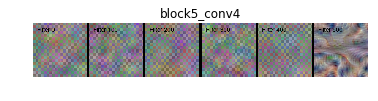

In [34]:
# Here we are visualizing the keras filters that we actually trained, (the last conv layer)
#
#
from vis.visualization import get_num_filters

layer_name = 'block5_conv4'
layer_idx = utils.find_layer_idx(model, layer_name)
filters = np.arange(get_num_filters(model.layers[layer_idx]))

scarce = [fil for i, fil in enumerate(filters) if i % 100 == 0]

vis_images = []
for i, idx in enumerate(scarce):
    img = visualize_activation(model, layer_idx, filter_indices=idx, input_modifiers=[Jitter(0.05)], verbose=True)
    
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()






In [36]:
new_vis_images = []
for i, idx in enumerate(scarce):
    img = visualize_activation(model, layer_idx, filter_indices=idx, seed_input=new_vis_images[i], input_modifiers=[Jitter(0.05)])
    
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    new_vis_images.append(img)

stitched = utils.stitch_images(new_vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

IndexError: list index out of range